- Function to process Mice
- Function to perform AE
- Function to perform Kmeans SMOTE
- Function to perform all the EDA
  - Isolation forest
  - Z score
  - Non linear relationships
- Function to perform PCA

    The above all comes under the main function

    
- Function to give out Plots and other EDA after the PCA is done. It gets the PCA dataset as the input

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import time
import os

import shap
import lime
from lime import lime_tabular


from sklearn.ensemble import IsolationForest
from scipy import stats
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from statsmodels.stats.outliers_influence import variance_inflation_factor

from imblearn.over_sampling import SVMSMOTE, ADASYN

from sklearn import metrics
from sklearn.metrics import confusion_matrix

from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import precision_recall_curve

from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import missingno as msno
from mpl_toolkits.mplot3d import Axes3D

from fancyimpute import IterativeImputer as MICE
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam 

from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import DBSCAN
from imblearn.over_sampling import SMOTE
from sklearn.neighbors import NearestNeighbors
from collections import Counter

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

from imblearn.over_sampling import KMeansSMOTE
from sklearn.mixture import GaussianMixture


from xgboost import XGBClassifier
from rgf.sklearn import RGFClassifier  # Regularized Greedy Forest
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense


from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from joblib import dump, load
import logging

import time


In [6]:
def preprocess_dataframe(df):

    start_time = time.time()  # Start timing

    # Replace LABEL values
    df["LABEL"] = df["LABEL"].replace({0: "Normal", 1: "Distressed"})
    df["ID"] = df["ID"].replace({0: "changed"})
    
    # Select columns from A36 to LABEL
    selected_columns = df.loc[:, 'A36':'LABEL']
    
    # Drop columns not in the selected range
    df_selected = df.drop(columns=df.columns.difference(selected_columns.columns))
    df_label = df_selected.copy()
    
    # Count the number of zeros in each row
    zeros_count = (df_label == 0).sum(axis=1)
    
    # Filter out rows with different zero thresholds
    filtered_df2L = df_label[zeros_count <= 2]
    filtered_df3L = df_label[zeros_count <= 3]
    filtered_df4L = df_label[zeros_count <= 4]
    filtered_df5L = df_label[zeros_count <= 5]
    filtered_df8L = df_label[zeros_count <= 8]
    filtered_df10L = df_label[zeros_count <= 10]
    
    
    # Replace 0 with NaN values in all filtered dataframes
    filtered_df2 = filtered_df2L.replace(0, np.nan)
    filtered_df3 = filtered_df3L.replace(0, np.nan)
    filtered_df4 = filtered_df4L.replace(0, np.nan)
    filtered_df5 = filtered_df5L.replace(0, np.nan)
    filtered_df8 = filtered_df8L.replace(0, np.nan)
    filtered_df10 = filtered_df10L.replace(0, np.nan)
    
    # Print info of the final dataframe with the strictest zero threshold
    # filtered_df2.drop("LABEL", axis=1).info()

    #print(filtered_df2.head(3))

    end_time = time.time()  # End timing
    elapsed_time = (end_time - start_time) / 60
    print(f"Time taken for preprocess_dataframe: {elapsed_time:.2f} mins")

    print("This is in preprocess")
    print(filtered_df3.isnull().sum())
    
    return {
        "filtered_df2": filtered_df2,
        "filtered_df3": filtered_df3,
        "filtered_df4": filtered_df4,
        "filtered_df5": filtered_df5,
        "filtered_df8": filtered_df8,
        "filtered_df10": filtered_df10,
        "filtered_df2L": filtered_df2L,
        "filtered_df3L": filtered_df3L,
        "filtered_df4L": filtered_df4L,
        "filtered_df5L": filtered_df5L,
        "filtered_df8L": filtered_df8L,
        "filtered_df10L": filtered_df10L
    }


def impute_with_mice(df, dfL):

    start_time = time.time()  # Start timing

    df = df.drop("LABEL", axis=1)

    #n_jobs=-1
    estimator = RandomForestRegressor(n_estimators=50, random_state=0)
    
    # Create the MICE imputer object
    imputer = IterativeImputer(estimator=estimator, max_iter=10, random_state=0)
    
    # Fit the imputer to the data and transform it
    df_mice = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)
    
    # Display the first few rows of the imputed DataFrame
    #print("Dataframe before MICE imputation: \n", df.head(3))
    #print("DataFrame after MICE imputation:\n", df_mice.head(3))
    
    # Saving the labels back in the dataframe
    labels = dfL["LABEL"]
    print("Length of labels: ", len(labels))
    
    # Reassigning the values in LABEL column
    df_mice["LABEL"] = labels.values
    
    end_time = time.time()  # End timing
    elapsed_time = (end_time - start_time) / 60

    print(f"Time taken for impute_with_mice: {elapsed_time:.2f} mins")


    return df_mice


def impute_with_autoencoder(df, dfL):

    start_time = time.time()  # Start timing

    # To further process the numerical columns
    df = df.drop("LABEL", axis=1)
    
    
    # Fill the nan with 0 for autoencoder training
    df_replaced = df.replace(np.nan, 0)

    # Normalize data
    scaler = StandardScaler()
    df_scaled = scaler.fit_transform(df_replaced)
    
    # Split data into train and validation sets
    X_train, X_val = train_test_split(df_scaled, test_size=0.2, random_state=42)
    
    # Define the autoencoder architecture
    input_dim = X_train.shape[1]
    encoding_dim = int(input_dim / 2)
    input_layer = Input(shape=(input_dim,))
    encoded = Dense(encoding_dim, activation='relu', kernel_regularizer='l2')(input_layer)
    decoded = Dense(input_dim, activation='linear')(encoded)
    autoencoder = Model(input_layer, decoded)
    autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
    
    # Print model summary
    autoencoder.summary()
    
    # Train the autoencoder
    history = autoencoder.fit(X_train, X_train,
                              epochs=35,
                              batch_size=32,
                              shuffle=True,
                              validation_data=(X_val, X_val))
    
    # Predict using the original df_scaled (with zeros)
    data_imputed_scaled = autoencoder.predict(df_scaled)
    
    # Inverse transform to get data_imputed_df
    data_imputed = scaler.inverse_transform(data_imputed_scaled)
    data_imputed_df = pd.DataFrame(data_imputed, columns=df.columns, index=df.index)
    
    # Saving a copy version
    df_AEimputed = df.copy()
    
    # Replace only the missing values with imputed values
    for col in df.columns:
        mask = df[col].isnull()
        df_AEimputed.loc[mask, col] = data_imputed_df.loc[mask, col]
    
    #print("Original Data with Missing Values:\n", df.isnull().sum())
    #print("Data after Autoencoder Imputation:\n", df_AEimputed.isnull().sum())
    
    # Reassign values of LABEL column back to the dataset
    df_AEimputed["LABEL"] = dfL["LABEL"].values

    end_time = time.time()  # End timing
    elapsed_time = (end_time - start_time) / 60
    print(f"Time taken for impute_with_autoencoder: {elapsed_time:.2f} mins")

    print("This is in autoencoder imputed")
    print(df_AEimputed.isnull().sum())
    

    
    return df_AEimputed


def reprocess_for_smote_pca(df_imputed):

    start_time = time.time()  # Start timing

    """
    Reprocess the imputed dataframe for SMOTE and PCA by replacing string values in the "LABEL" column with binary values.
    
    Parameters:
    df_imputed (pd.DataFrame): The imputed dataframe with "LABEL" column containing string values.
    
    Returns:
    pd.DataFrame: The reprocessed dataframe with binary values in the "LABEL" column.
    """
    df_reprocessed = df_imputed.copy()
    df_reprocessed["LABEL"] = df_reprocessed["LABEL"].replace({"Normal": 0, "Distressed": 1}).infer_objects(copy=False)

    end_time = time.time()  # End timing
    elapsed_time = (end_time - start_time) / 60
    print(f"Time taken for reprocess_for_smote_pca: {elapsed_time:.2f} mins")

    print("This is in RRReprocessed::::::::")
    print(df_reprocessed.isnull().sum())
    
        
    
    return df_reprocessed



def adasyn_resampling(df):
    start_time = time.time()  # Start timing

    # Preprocessing
    X = df.drop(columns=["LABEL"])
    y = df["LABEL"]

    # Separate the classes
    X_minority = X[y == 1]
    X_majority = X[y == 0]

    # Visualize the minority class
    plt.scatter(X_minority.iloc[:, 0], X_minority.iloc[:, 1], label='Minority Class', alpha=0.6)
    plt.title("Minority Class Distribution")
    plt.legend()
    plt.show()

    # Standardize the features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Apply ADASYN
    adasyn = ADASYN(random_state=42)
    X_resampled, y_resampled = adasyn.fit_resample(X_scaled, y)

    # Verify the balance of the new dataset
    print("Original class distribution:", Counter(y))
    print("Resampled class distribution:", Counter(y_resampled))

    # Convert X_resampled back to original scale
    X_resampled = scaler.inverse_transform(X_resampled)

    # Convert X_resampled and y_resampled to DataFrames
    X_resampled_df = pd.DataFrame(X_resampled, columns=X.columns)
    y_resampled_df = pd.DataFrame(y_resampled, columns=['LABEL'])

    # Concatenate X_resampled_df and y_resampled_df along columns axis
    resampled_df = pd.concat([X_resampled_df, y_resampled_df], axis=1)

    # Save resampled DataFrame to Excel (uncomment if needed)
    # resampled_df.to_excel('df_autoencoder_ADASYN.xlsx', index=False)

    df_processed = resampled_df.copy()

    # Visualize the resampled dataset
    plt.scatter(X_resampled[y_resampled == 0][:, 0], X_resampled[y_resampled == 0][:, 1], label='Majority Class', alpha=0.6)
    plt.scatter(X_resampled[y_resampled == 1][:, 0], X_resampled[y_resampled == 1][:, 1], label='Minority Class', alpha=0.6)
    plt.title("Resampled Dataset Distribution")
    plt.legend()
    plt.show()

    end_time = time.time()  # End timing
    elapsed_time = (end_time - start_time) / 60
    print(f"Time taken for adasyn_resampling: {elapsed_time:.2f} mins")

    return df_processed




def process_pca(df):
    start_time = time.time()  # Start timing

    print("This is in PCA initial:::::::")
    print(df.isnull().sum())

    def compute_pca(df, columns, n_components=2):
        # Standardize the data
        scaler = StandardScaler()
        scaled_data = scaler.fit_transform(df[columns])
        
        # Compute PCA
        pca = PCA(n_components=n_components)
        pca_data = pca.fit_transform(scaled_data)
        
        # Create a DataFrame with the PCA results
        pca_columns = [f'PC{i+1}' for i in range(n_components)]
        pca_df = pd.DataFrame(pca_data, columns=pca_columns)
        
        return pca_df

    def pca_transformed_df(df, ratio_categories, n_components=2):
        pca_results = []

        for category, columns in ratio_categories.items():
            pca_df = compute_pca(df, columns, n_components)
            pca_df = pca_df.add_prefix(f'{category}_')
            pca_results.append(pca_df)

        combined_pca_df = pd.concat(pca_results, axis=1)
        return combined_pca_df

    # Define your ratio categories and their respective columns
    ratio_categories = {
        "Liquidity_and_Coverage_Ratios" :  ['A36', 'A37', 'A38', 'A44', 'A41', 'A43'],
        "Leverage_Ratios" : ['A39', 'A40', 'A42', 'A48', 'A71', 'A72', 'A73'],
        "Activity_Ratios" :  ['A45', 'A46', 'A47', 'A50','A53', 'A54', 'A56'],
        "Profitability_Ratios" :  ['A49', 'A57', 'A58', 'A59', 'A61', 'A62'],
        "Cost_and_Expense_Ratios" :  ['A63', 'A64', 'A65', 'A66'],
        "Cash_Flow_Ratios" : ['A67', 'A68', 'A69', 'A70'],
        "Growth_Ratios" : ['A74', 'A75', 'A76', 'A77', 'A78', 'A79', 'A80', 'A81'],
        "Per_Share_Ratios" :  ['A82', 'A83', 'A84']
    }

    # Compute PCA and get the combined DataFrame
    combined_pca_df = pca_transformed_df(df, ratio_categories, n_components=2)

    print("This is in PCA processed prior to label allotment")
    print(combined_pca_df.isnull().sum())

    # Reset the index of both DataFrames to ensure alignment
    combined_pca_df.reset_index(drop=True, inplace=True)
    df.reset_index(drop=True, inplace=True)

    # Add the LABEL column back to the combined PCA DataFrame
    combined_pca_df["LABEL"] = df["LABEL"]

    # Save the combined PCA DataFrame to a CSV file (optional)
    # combined_pca_df.to_csv('combined_pca_ratios.csv', index=False)

    # Display the first few rows of the combined PCA DataFrame
    print(combined_pca_df.head(3))

    end_time = time.time()  # End timing
    elapsed_time = (end_time - start_time) / 60
    print(f"Time taken for process_pca: {elapsed_time:.2f} mins")

    print("This is in PCA processed")
    print(combined_pca_df.isnull().sum())
    
    return combined_pca_df


def visualize_high_dim_data(df, filename, title, n_components=2, perplexity=30, random_state=42):
    """
    Visualize high-dimensional data using t-SNE.
    
    Parameters:
    df (pandas.DataFrame): Input DataFrame
    n_components (int): Number of dimensions to reduce to (default 2)
    perplexity (float): Perplexity parameter for t-SNE (default 30)
    random_state (int): Random state for reproducibility (default 42)
    
    Returns:
    None (displays plot)
    """
    # Prepare the data
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    X = df[numeric_cols].values
    
    # Standardize the data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Perform t-SNE
    tsne = TSNE(n_components=n_components, perplexity=perplexity, random_state=random_state)
    tsne_results = tsne.fit_transform(X_scaled)
    
    # Visualize results
    plt.figure(figsize=(10, 8))
    
    # t-SNE plot
    scatter = plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=range(len(X)), cmap='viridis')
    plt.title(f"t-SNE Visualization : {title} ")
    plt.xlabel('t-SNE 1')
    plt.ylabel('t-SNE 2')
    plt.colorbar(scatter, label='Data Point Index')
    
    plt.savefig(filename, dpi = 300)

    plt.tight_layout()
    plt.show()

# this is to check the underlying pattern of the data - linear or non-linear
def compare_linear_non_linear_models(df, target_column='LABEL'):
    
    df_patterns = df.copy()
    df_patterns["LABEL"] = df_patterns["LABEL"].replace({"Normal": 0, "Distressed": 1}).infer_objects(copy=False)

    # Split the data into features and target
    X = df_patterns.drop(columns=[target_column])
    y = df_patterns[target_column]

    # Calculate Pearson and Spearman correlations
    pearson_corr = df_patterns.corr(method='pearson')[target_column].drop(target_column)
    spearman_corr = df_patterns.corr(method='spearman')[target_column].drop(target_column)
    
    # Combine correlations into a DataFrame
    corr_df = pd.DataFrame({
        'Pearson': pearson_corr,
        'Spearman': spearman_corr
    }).sort_values('Spearman', key=abs, ascending=False)
    
    # Calculate the difference between Pearson and Spearman
    corr_df['Difference'] = corr_df['Pearson'] - corr_df['Spearman']
    
    # Print correlations
    print("Pearson and Spearman Correlations:")
    print(corr_df)


def comprehensive_analysis(df):
    # Create a copy of the dataframe
    df_analysis = df.copy()
    
    print("The null values before isolation forest")
    print(df_analysis.isnull().sum())
    
    # Convert LABEL to numeric
    df_analysis["LABEL"] = df_analysis["LABEL"].replace({"Normal": 0, "Distressed": 1})
    
    print("The null values before isolation forest")
    print(df_analysis.isnull().sum())

    # 1. Basic statistics and missing values
    print("Basic Statistics:")
    print(df_analysis.describe())
    #print("\nMissing Values:")
    #print(df_analysis.isnull().sum())
    
    # 2. Correlation analysis
    corr_matrix = df_analysis.corr()
    plt.figure(figsize=(20, 16))
    sns.heatmap(corr_matrix, cmap='coolwarm', annot=False)
    plt.title('Correlation Heatmap')
    plt.tight_layout()
    plt.show()
    
    # 3. Identify highly correlated features
    high_corr = np.where(np.abs(corr_matrix) > 0.8)
    high_corr_pairs = [(corr_matrix.index[x], corr_matrix.columns[y]) 
                       for x, y in zip(*high_corr) if x != y and x < y]
    print("\nHighly correlated feature pairs:")
    for pair in high_corr_pairs:
        print(f"{pair[0]} - {pair[1]}: {corr_matrix.loc[pair[0], pair[1]]:.2f}")
    
    # 4. Outlier detection using multiple methods
    # Prepare data for outlier detection (exclude non-numeric columns)
    numeric_cols = df_analysis.select_dtypes(include=[np.number]).columns
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(df_analysis[numeric_cols])

    
    # Isolation Forest
    iso_forest = IsolationForest(contamination=0.1, random_state=42)
    outliers_iso = iso_forest.fit_predict(scaled_data)
    
    # Z-score
    z_scores = np.abs(stats.zscore(df_analysis[numeric_cols]))
    outliers_z = np.where(z_scores > 3)
    
    print(f"\nNumber of potential outliers (Isolation Forest): {sum(outliers_iso == -1)}")
    print(f"Number of potential outliers (Z-score > 3): {len(outliers_z[0])}")
    
    # 5. Skewness and Kurtosis analysis
    skewness = df_analysis[numeric_cols].skew()
    kurtosis = df_analysis[numeric_cols].kurtosis()
    print("\nSkewness of features:")
    print(skewness)
    print("\nKurtosis of features:")
    print(kurtosis)


def kmeans_smote_resampling(df):

    start_time = time.time()  # Start timing

    # Preprocessing
    X = df.drop(columns=["LABEL"])
    y = df["LABEL"]
    
    # Separate the classes
    X_minority = X[y == 1]
    X_majority = X[y == 0]
    
    # Visualize the minority class
    plt.scatter(X_minority.iloc[:, 0], X_minority.iloc[:, 1], label='Minority Class', alpha=0.6)
    plt.title("Minority Class Distribution")
    plt.legend()
    plt.show()
    
    # Define the KMeans estimator with a higher number of clusters and set n_init explicitly
    kmeans_estimator = KMeans(n_clusters=5, random_state=42, n_init=10)
    
    # Apply KMeans-SMOTE to the entire dataset with adjusted parameters
    kmeans_smote = KMeansSMOTE(kmeans_estimator=kmeans_estimator, cluster_balance_threshold=0.01, random_state=42)
    X_resampled, y_resampled = kmeans_smote.fit_resample(X, y)
    
    # Verify the balance of the new dataset
    print("Original class distribution:", Counter(y))
    print("Resampled class distribution:", Counter(y_resampled))
    
    # Convert X_resampled and y_resampled to DataFrames
    X_resampled_df = pd.DataFrame(X_resampled, columns=X.columns)  # Assuming X has column names
    y_resampled_df = pd.DataFrame(y_resampled, columns=['LABEL'])  # Adjust column name as needed
    
    # Concatenate X_resampled_df and y_resampled_df along columns axis
    resampled_df = pd.concat([X_resampled_df, y_resampled_df], axis=1)
    
    # Save resampled DataFrame to Excel
    # resampled_df.to_excel('df_autoencoder_KM_SMOTE.xlsx', index=False)
    
    df_processed = resampled_df.copy()
    
    # Visualize the resampled dataset
    plt.scatter(X_resampled[y_resampled == 0].iloc[:, 0], X_resampled[y_resampled == 0].iloc[:, 1], label='Majority Class', alpha=0.6)
    plt.scatter(X_resampled[y_resampled == 1].iloc[:, 0], X_resampled[y_resampled == 1].iloc[:, 1], label='Minority Class', alpha=0.6)
    plt.title("Resampled Dataset Distribution")
    plt.legend()
    plt.show()

    end_time = time.time()  # End timing
    elapsed_time = (end_time - start_time) / 60
    print(f"Time taken for kmeans_smote_resampling: {elapsed_time:.2f} mins")
    
    return df_processed


def svmsmote_resampling(df):
    start_time = time.time()  # Start timing

    # Preprocessing
    X = df.drop(columns=["LABEL"])
    y = df["LABEL"]

    # Separate the classes
    X_minority = X[y == 1]
    X_majority = X[y == 0]

    # Visualize the minority class
    plt.scatter(X_minority.iloc[:, 0], X_minority.iloc[:, 1], label='Minority Class', alpha=0.6)
    plt.title("Minority Class Distribution")
    plt.legend()
    plt.show()

    # Standardize the features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Apply SVMSMOTE
    svmsmote = SVMSMOTE(random_state=42)
    X_resampled, y_resampled = svmsmote.fit_resample(X_scaled, y)

    # Verify the balance of the new dataset
    print("Original class distribution:", Counter(y))
    print("Resampled class distribution:", Counter(y_resampled))

    # Convert X_resampled back to original scale
    X_resampled = scaler.inverse_transform(X_resampled)

    # Convert X_resampled and y_resampled to DataFrames
    X_resampled_df = pd.DataFrame(X_resampled, columns=X.columns)
    y_resampled_df = pd.DataFrame(y_resampled, columns=['LABEL'])

    # Concatenate X_resampled_df and y_resampled_df along columns axis
    resampled_df = pd.concat([X_resampled_df, y_resampled_df], axis=1)

    # Save resampled DataFrame to Excel (uncomment if needed)
    # resampled_df.to_excel('df_autoencoder_SVMSMOTE.xlsx', index=False)

    df_processed = resampled_df.copy()

    # Visualize the resampled dataset
    plt.scatter(X_resampled[y_resampled == 0][:, 0], X_resampled[y_resampled == 0][:, 1], label='Majority Class', alpha=0.6)
    plt.scatter(X_resampled[y_resampled == 1][:, 0], X_resampled[y_resampled == 1][:, 1], label='Minority Class', alpha=0.6)
    plt.title("Resampled Dataset Distribution")
    plt.legend()
    plt.show()

    end_time = time.time()  # End timing
    elapsed_time = (end_time - start_time) / 60
    print(f"Time taken for svmsmote_resampling: {elapsed_time:.2f} mins")

    return df_processed



def main(df):

    main_start_time = time.time()

    print("Executing the main function.")
    datasets = preprocess_dataframe(df)
    print("Preprocessed Datasets.")
    
    print("Results on comparing the data for pattern check before preprocessing")
    compare_linear_non_linear_models(datasets["filtered_df3L"])
    
    print("Comprehensive analysis on primary dataset prior to processing:")
    comprehensive_analysis(datasets["filtered_df3L"])
    
    print(" ------------  TSNE before the processing -------------- ")
    
    
    # MICE Processing
    print("_______________________________________________________________________________")
    print("*******************************************************************************")
    print("                      Proceedings for MICE :")
    print("_______________________________________________________________________________")
    print("*******************************************************************************")
    
    start_time = time.time()
    mice_imputed_df = impute_with_mice(datasets["filtered_df3"], datasets["filtered_df3L"])
    mice_elapsed_time = (time.time() - start_time) / 60
    print(f" Total time taken for MICE: {mice_elapsed_time:.2f} mins")
    
    print(" ------------  TSNE after MICE processing -------------- ")
    
    
    df_mice_reprocessed = reprocess_for_smote_pca(mice_imputed_df)
    
    start_time = time.time()
    #df_mice_adasyn_resampled = adasyn_resampling(df_mice_reprocessed)
    adasyn_elapsed_time = (time.time() - start_time) / 60
    print(f" Total time taken for ADASYN on MICE dataset: {adasyn_elapsed_time:.2f} mins")

    print(" ------------  TSNE after ADASYN on MICE dataset processing -------------- ")
    
    
    pca_df_mice = process_pca(df_mice_reprocessed)
    
    print("Comprehensive analysis on MICE processed dataset :")
    comprehensive_analysis(pca_df_mice)
    
    print("Results on comparing the data for pattern check after preprocessing with MICE")
    compare_linear_non_linear_models(pca_df_mice)

    print("_______________________________________________________________________________")
    print(f"Total time taken for MICE: {mice_elapsed_time:.2f} mins")
    #print(f" Total time taken for ADASYN on MICE dataset: {adasyn_elapsed_time:.2f} mins")
    print("_______________________________________________________________________________")


    print(" ")
    print(" ")
    print(" ")
    print(" ")
    
    # Autoencoder Processing
    print("_______________________________________________________________________________")
    print("*******************************************************************************")
    print("                    Proceedings for Autoencoder :")
    print("_______________________________________________________________________________")
    print("*******************************************************************************")

    start_time = time.time()
    ae_imputed_df = impute_with_autoencoder(datasets["filtered_df3"], datasets["filtered_df3L"])
    ae_elapsed_time = (time.time() - start_time) / 60
    print(f" Total time taken for Autoencoders: {ae_elapsed_time:.2f} mins")
    
    print(" ------------  TSNE after Autoencoder (AE) processing -------------- ")
    #

    df_autoencoder_reprocessed = reprocess_for_smote_pca(ae_imputed_df)
    
    start_time = time.time()
    #df_autoencoder_adasyn_resampled = adasyn_resampling(df_autoencoder_reprocessed)
    adasyn_elapsed_time = (time.time() - start_time) / 60
    print(f" Total time taken for ADASYN on Autoencoders dataset: {adasyn_elapsed_time:.2f} mins")

    print(" ------------  TSNE after Autoencoder (AE) and ADASYN processing -------------- ")
    #
    
    pca_df_autoencoder = process_pca(df_autoencoder_reprocessed)
    
    print("Comprehensive analysis on Autoencoder processed dataset :")
    comprehensive_analysis(pca_df_autoencoder)
    
    print("Results on comparing the data for pattern check after preprocessing with Autoencoders")
    compare_linear_non_linear_models(pca_df_autoencoder)

    pca_df_mice.to_excel("MICE_PCA.xlsx", index=False)
    pca_df_autoencoder.to_excel("AE_PCA.xlsx", index=False)

    print("_______________________________________________________________________________")
    print(f" Total time taken for Autoencoders: {ae_elapsed_time:.2f} mins")
    #print(f" Total time taken for ADASYN on Autoencoders dataset: {adasyn_elapsed_time:.2f} mins")
    print("_______________________________________________________________________________")

    print(" ")
    print(" ")
    print(" ")
    print(" ")


    main_elapsed_time = (time.time() - main_start_time) / 60
    print(" ")
    
    print(f" Total time taken for ADASYN on Autoencoders dataset: {adasyn_elapsed_time:.2f} mins")
    print(f" Total time taken for ADASYN on MICE dataset: {adasyn_elapsed_time:.2f} mins")
    print(" ")
    print(f" Total time taken for main function execution: {main_elapsed_time:.2f} mins")


In [7]:
df = pd.read_excel("C:\\Users\\dev\\Desktop\\financial distress\\financial_distress_python.xlsx")

Executing the main function.
Time taken for preprocess_dataframe: 0.00 mins
This is in preprocess
A36         0
A37         0
A38       123
A39       308
A40         0
A41         0
A42         0
A43         0
A44         0
A45       160
A46         3
A47         0
A48         0
A49         4
A50       160
A53       789
A54         4
A56       160
A57         0
A58         0
A59         0
A61         0
A62         0
A63       789
A64         0
A65        43
A66       308
A67        15
A68         8
A69         8
A70         8
A71         1
A72       120
A73       122
A74         1
A75         0
A76         0
A77         5
A78         6
A79         3
A80        97
A81         0
A82      3352
A83      3352
A84      3367
LABEL       0
dtype: int64
Preprocessed Datasets.
Results on comparing the data for pattern check before preprocessing


C:\Users\dev\AppData\Local\Temp\ipykernel_11556\488595549.py:375: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_patterns["LABEL"] = df_patterns["LABEL"].replace({"Normal": 0, "Distressed": 1}).infer_objects(copy=False)
C:\Users\dev\AppData\Local\Temp\ipykernel_11556\488595549.py:407: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_analysis["LABEL"] = df_analysis["LABEL"].replace({"Normal": 0, "Distressed": 1})


Pearson and Spearman Correlations:
      Pearson  Spearman  Difference
A44 -0.071560 -0.208907    0.137347
A40  0.076124  0.208907   -0.132783
A42 -0.071560 -0.208907    0.137347
A38 -0.034818 -0.198795    0.163977
A37 -0.049422 -0.193744    0.144323
A36 -0.052785 -0.186587    0.133803
A48  0.060547  0.186587   -0.126040
A64 -0.000357  0.168774   -0.169131
A46  0.005761 -0.159709    0.165470
A58 -0.001641 -0.156350    0.154709
A53 -0.002296 -0.156048    0.153752
A39 -0.006026 -0.154262    0.148236
A65 -0.001759  0.151417   -0.153175
A59 -0.001936 -0.139285    0.137349
A82 -0.004526 -0.139033    0.134508
A41 -0.075268 -0.128120    0.052852
A70 -0.013655 -0.121491    0.107836
A66  0.004019  0.121450   -0.117431
A83  0.004567 -0.117571    0.122138
A47 -0.003122 -0.107671    0.104549
A62 -0.001792 -0.104912    0.103119
A50 -0.001935  0.103271   -0.105206
A63  0.020103  0.099091   -0.078988
A57 -0.000546  0.098465   -0.099010
A68 -0.001843 -0.081364    0.079521
A80 -0.008335 -0.077398    0.

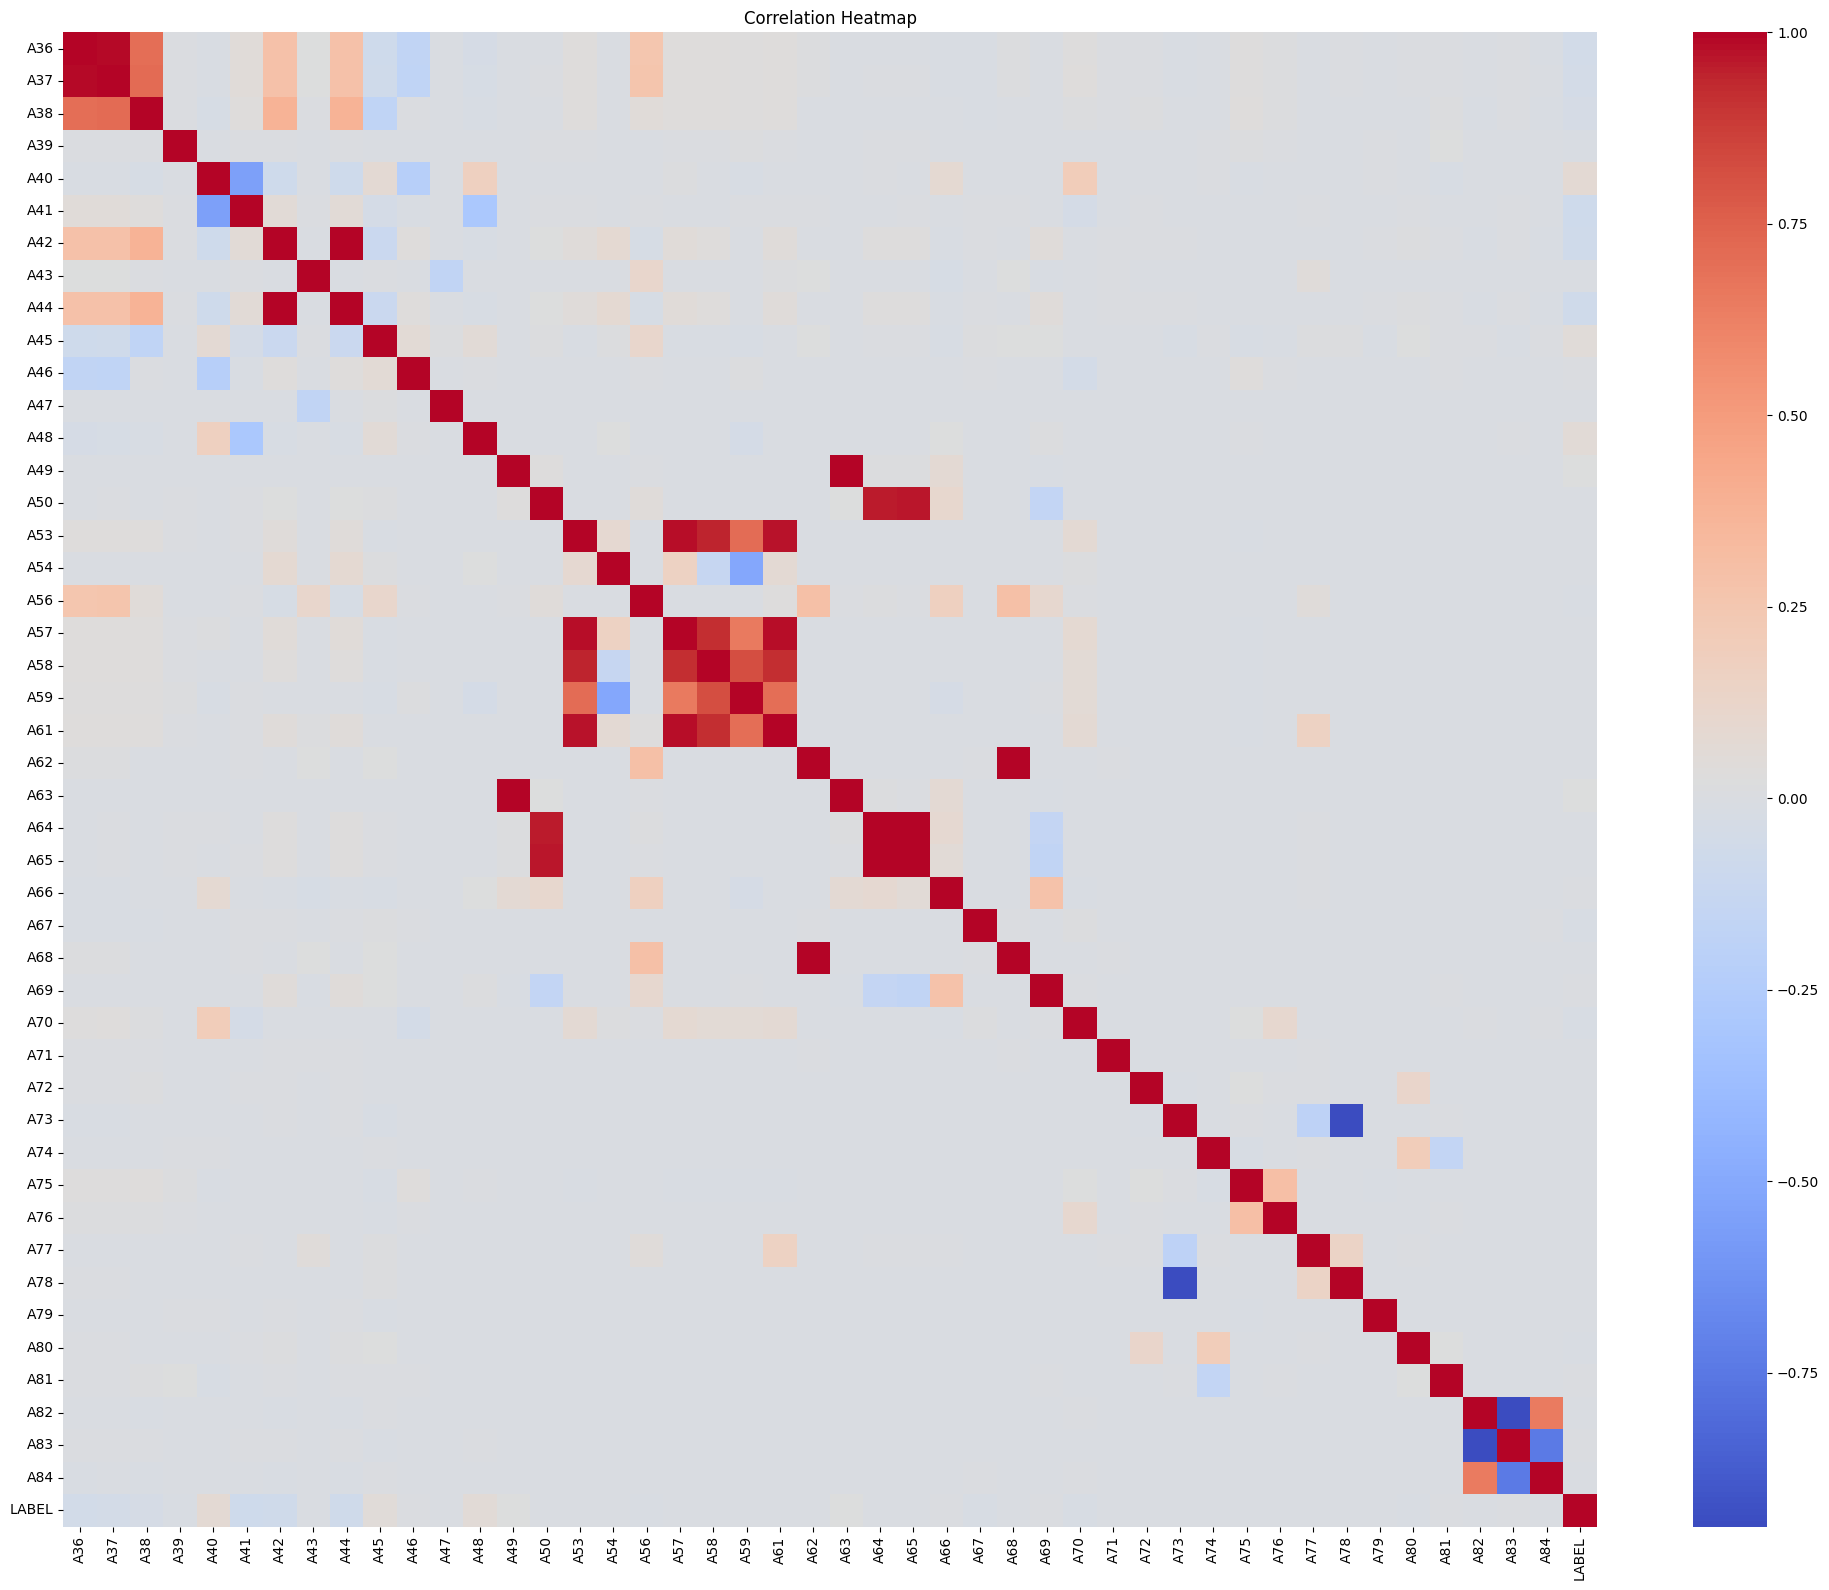


Highly correlated feature pairs:
A36 - A37: 0.99
A42 - A44: 1.00
A49 - A63: 1.00
A50 - A64: 0.96
A50 - A65: 0.97
A53 - A57: 0.98
A53 - A58: 0.94
A53 - A61: 0.97
A57 - A58: 0.92
A57 - A61: 0.98
A58 - A59: 0.82
A58 - A61: 0.92
A62 - A68: 1.00
A64 - A65: 1.00
A73 - A78: -0.94
A82 - A83: -0.95

Number of potential outliers (Isolation Forest): 1402
Number of potential outliers (Z-score > 3): 2048

Skewness of features:
A36       11.853959
A37       12.563713
A38       19.230577
A39       92.826627
A40       23.176508
A41      -44.478000
A42       15.575324
A43      -53.722598
A44       15.575324
A45        0.621959
A46      -21.737562
A47       99.696076
A48       52.564190
A49      101.725170
A50      105.927150
A53      112.645942
A54       74.679641
A56       25.852578
A57      112.588181
A58      109.329759
A59       26.478478
A61      109.457276
A62       84.054508
A63      101.707970
A64      115.887423
A65      115.988407
A66       39.638575
A67       12.941894
A68       84.154659
A

c:\Users\dev\Desktop\MSC thesis\Code\mscthesis\Lib\site-packages\sklearn\impute\_iterative.py:825: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


Length of labels:  14015
Time taken for impute_with_mice: 468.13 mins
 Total time taken for MICE: 468.37 mins
 ------------  TSNE after MICE processing -------------- 
Time taken for reprocess_for_smote_pca: 0.00 mins
This is in RRReprocessed::::::::
A36      0
A37      0
A38      0
A39      0
A40      0
A41      0
A42      0
A43      0
A44      0
A45      0
A46      0
A47      0
A48      0
A49      0
A50      0
A53      0
A54      0
A56      0
A57      0
A58      0
A59      0
A61      0
A62      0
A63      0
A64      0
A65      0
A66      0
A67      0
A68      0
A69      0
A70      0
A71      0
A72      0
A73      0
A74      0
A75      0
A76      0
A77      0
A78      0
A79      0
A80      0
A81      0
A82      0
A83      0
A84      0
LABEL    0
dtype: int64
 Total time taken for ADASYN on MICE dataset: 0.00 mins
 ------------  TSNE after ADASYN on MICE dataset processing -------------- 
This is in PCA initial:::::::
A36      0
A37      0
A38      0
A39      0
A40      0
A41      0
A4

C:\Users\dev\AppData\Local\Temp\ipykernel_11556\488595549.py:183: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_reprocessed["LABEL"] = df_reprocessed["LABEL"].replace({"Normal": 0, "Distressed": 1}).infer_objects(copy=False)


This is in PCA processed prior to label allotment
Liquidity_and_Coverage_Ratios_PC1    0
Liquidity_and_Coverage_Ratios_PC2    0
Leverage_Ratios_PC1                  0
Leverage_Ratios_PC2                  0
Activity_Ratios_PC1                  0
Activity_Ratios_PC2                  0
Profitability_Ratios_PC1             0
Profitability_Ratios_PC2             0
Cost_and_Expense_Ratios_PC1          0
Cost_and_Expense_Ratios_PC2          0
Cash_Flow_Ratios_PC1                 0
Cash_Flow_Ratios_PC2                 0
Growth_Ratios_PC1                    0
Growth_Ratios_PC2                    0
Per_Share_Ratios_PC1                 0
Per_Share_Ratios_PC2                 0
dtype: int64
   Liquidity_and_Coverage_Ratios_PC1  Liquidity_and_Coverage_Ratios_PC2  \
0                           0.311472                           0.207009   
1                           0.688013                           0.190342   
2                           0.129952                           0.236124   

   Leverage_

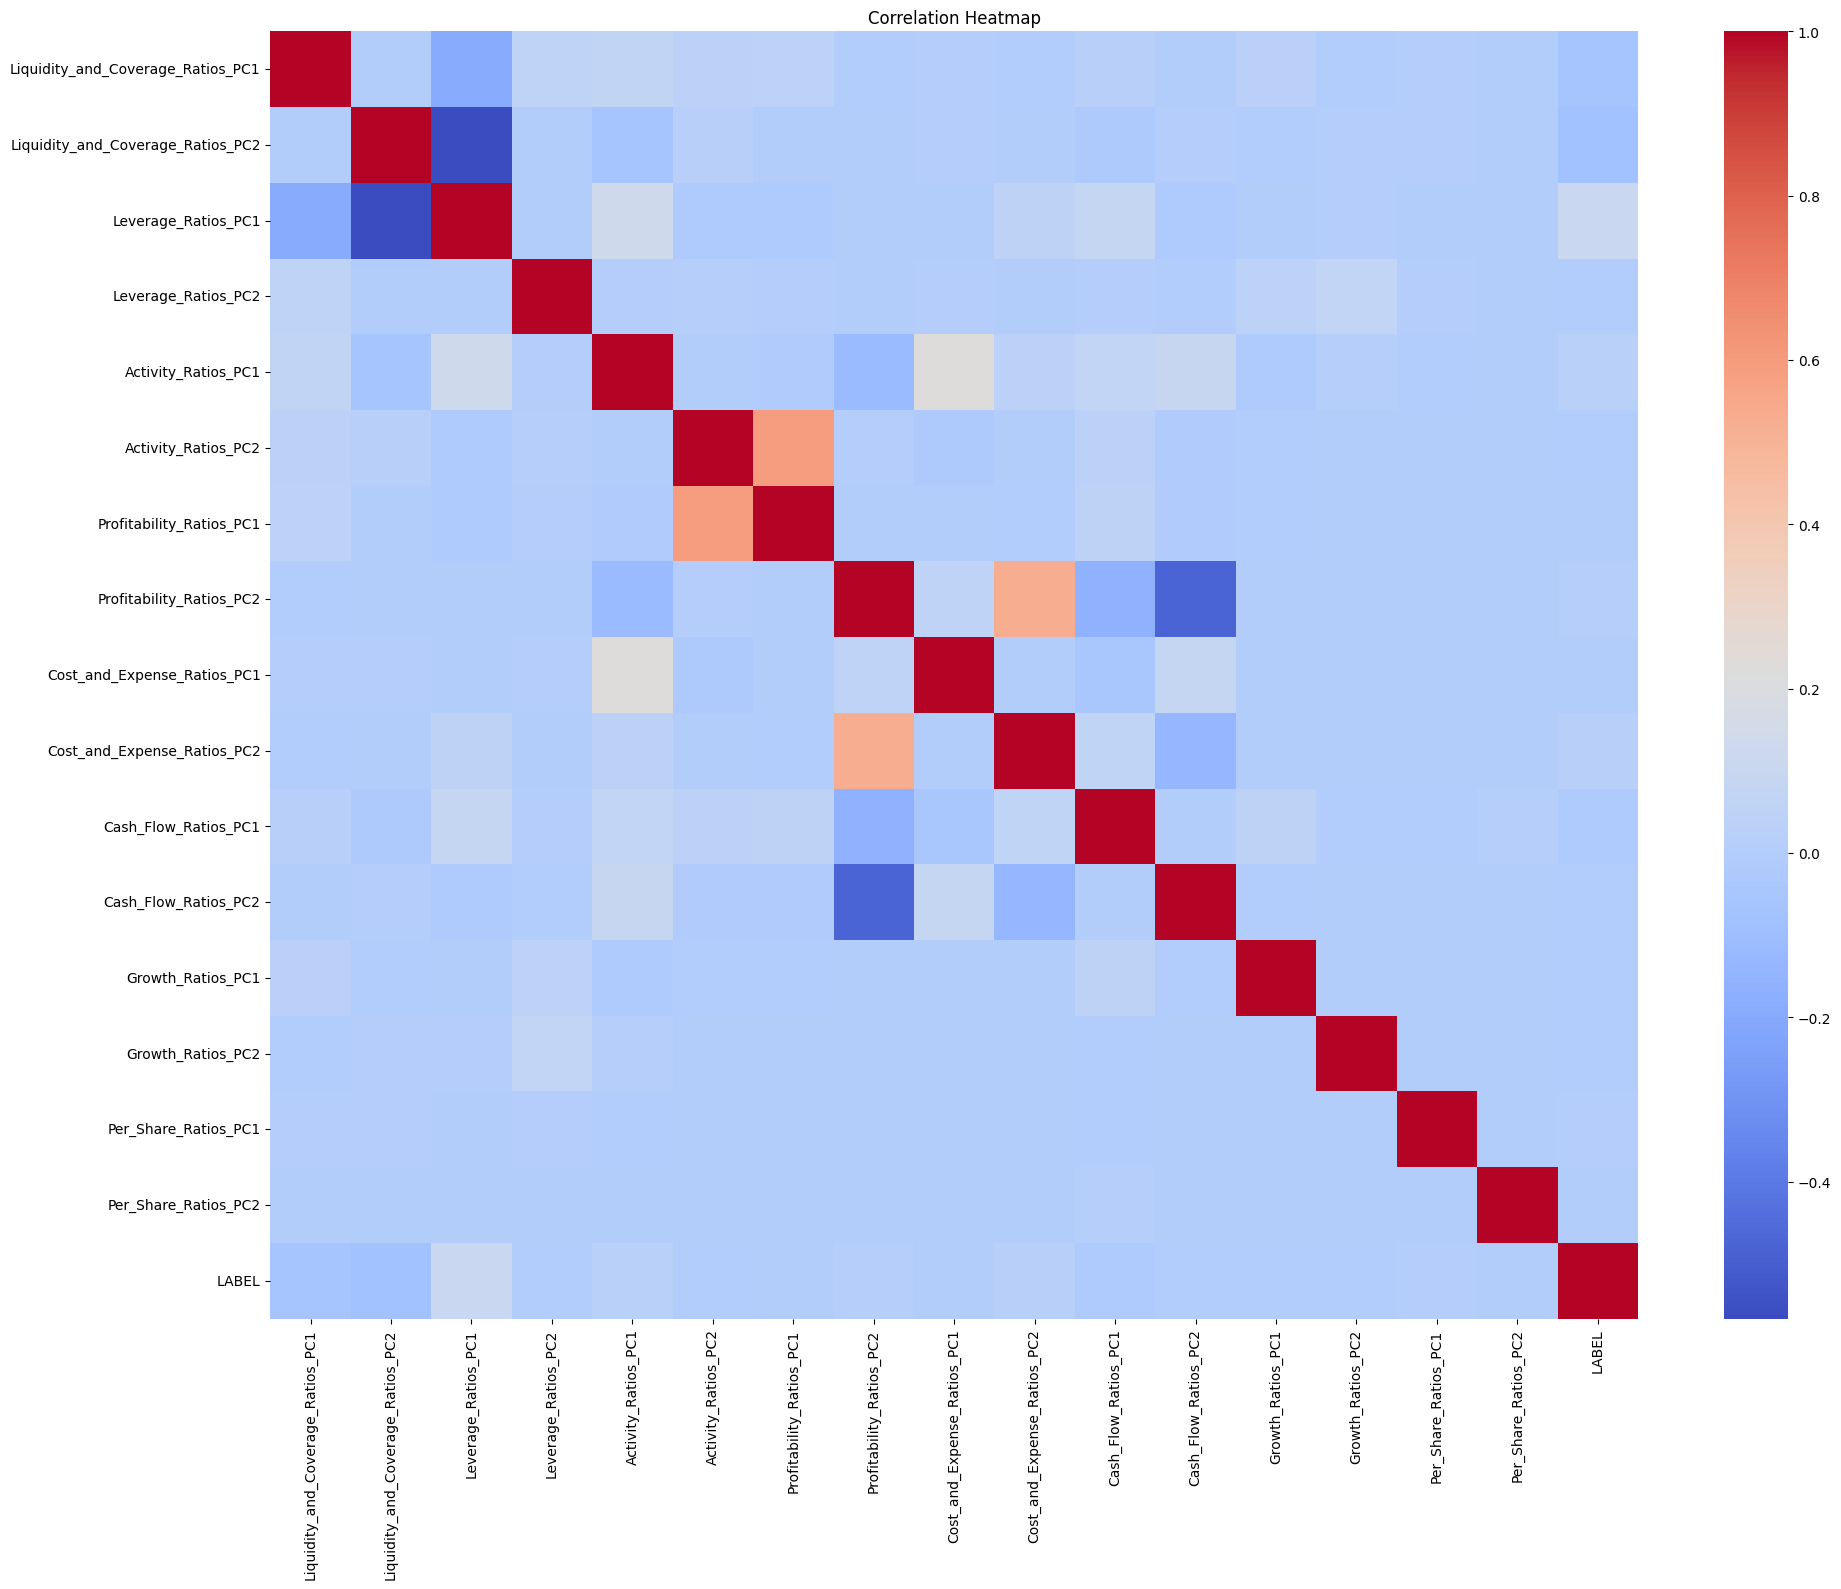


Highly correlated feature pairs:

Number of potential outliers (Isolation Forest): 1402
Number of potential outliers (Z-score > 3): 1182

Skewness of features:
Liquidity_and_Coverage_Ratios_PC1     14.050368
Liquidity_and_Coverage_Ratios_PC2    -40.680839
Leverage_Ratios_PC1                   20.873244
Leverage_Ratios_PC2                   37.450893
Activity_Ratios_PC1                    8.492808
Activity_Ratios_PC2                   64.061473
Profitability_Ratios_PC1             113.021494
Profitability_Ratios_PC2               6.257965
Cost_and_Expense_Ratios_PC1          112.926524
Cost_and_Expense_Ratios_PC2           49.891926
Cash_Flow_Ratios_PC1                  16.643469
Cash_Flow_Ratios_PC2                  17.644781
Growth_Ratios_PC1                     45.744986
Growth_Ratios_PC2                     62.219683
Per_Share_Ratios_PC1                 -38.151380
Per_Share_Ratios_PC2                   8.286962
LABEL                                  6.533223
dtype: float64

Kurtosi

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 45)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 22)             │         1,012 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 45)             │         1,035 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,047 (8.00 KB)

 Trainable params: 2,047 (8.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/35
351/351 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 1.2366 - val_loss: 0.8289
Epoch 2/35
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 653us/step - loss: 1.0790 - val_loss: 0.7381
Epoch 3/35
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 666us/step - loss: 0.8572 - val_loss: 0.6790
Epoch 4/35
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 664us/step - loss: 0.8501 - val_loss: 0.6404
Epoch 5/35
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 661us/step - loss: 0.8501 - val_loss: 0.6143
Epoch 6/35
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 667us/step - loss: 0.5350 - val_loss: 0.5981
Epoch 7/35
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 667us/step - loss: 0.5992 - val_loss: 0.5818
Epoch 8/35
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 687us/step - loss: 0.4761 - val_loss: 0.5732
Epoch 9/35
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 671us/step - loss: 0.3565 - val_loss: 0.5643
Epoch 10/35
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 691us/step - loss: 0.5134 - val_loss: 0.5576
Epoch 11/35
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 838us/step - loss: 0.4346 - val_loss: 0.5507
Epoch 12/35
351/351 ━━━━━━━━━━━━

C:\Users\dev\AppData\Local\Temp\ipykernel_11556\488595549.py:183: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_reprocessed["LABEL"] = df_reprocessed["LABEL"].replace({"Normal": 0, "Distressed": 1}).infer_objects(copy=False)


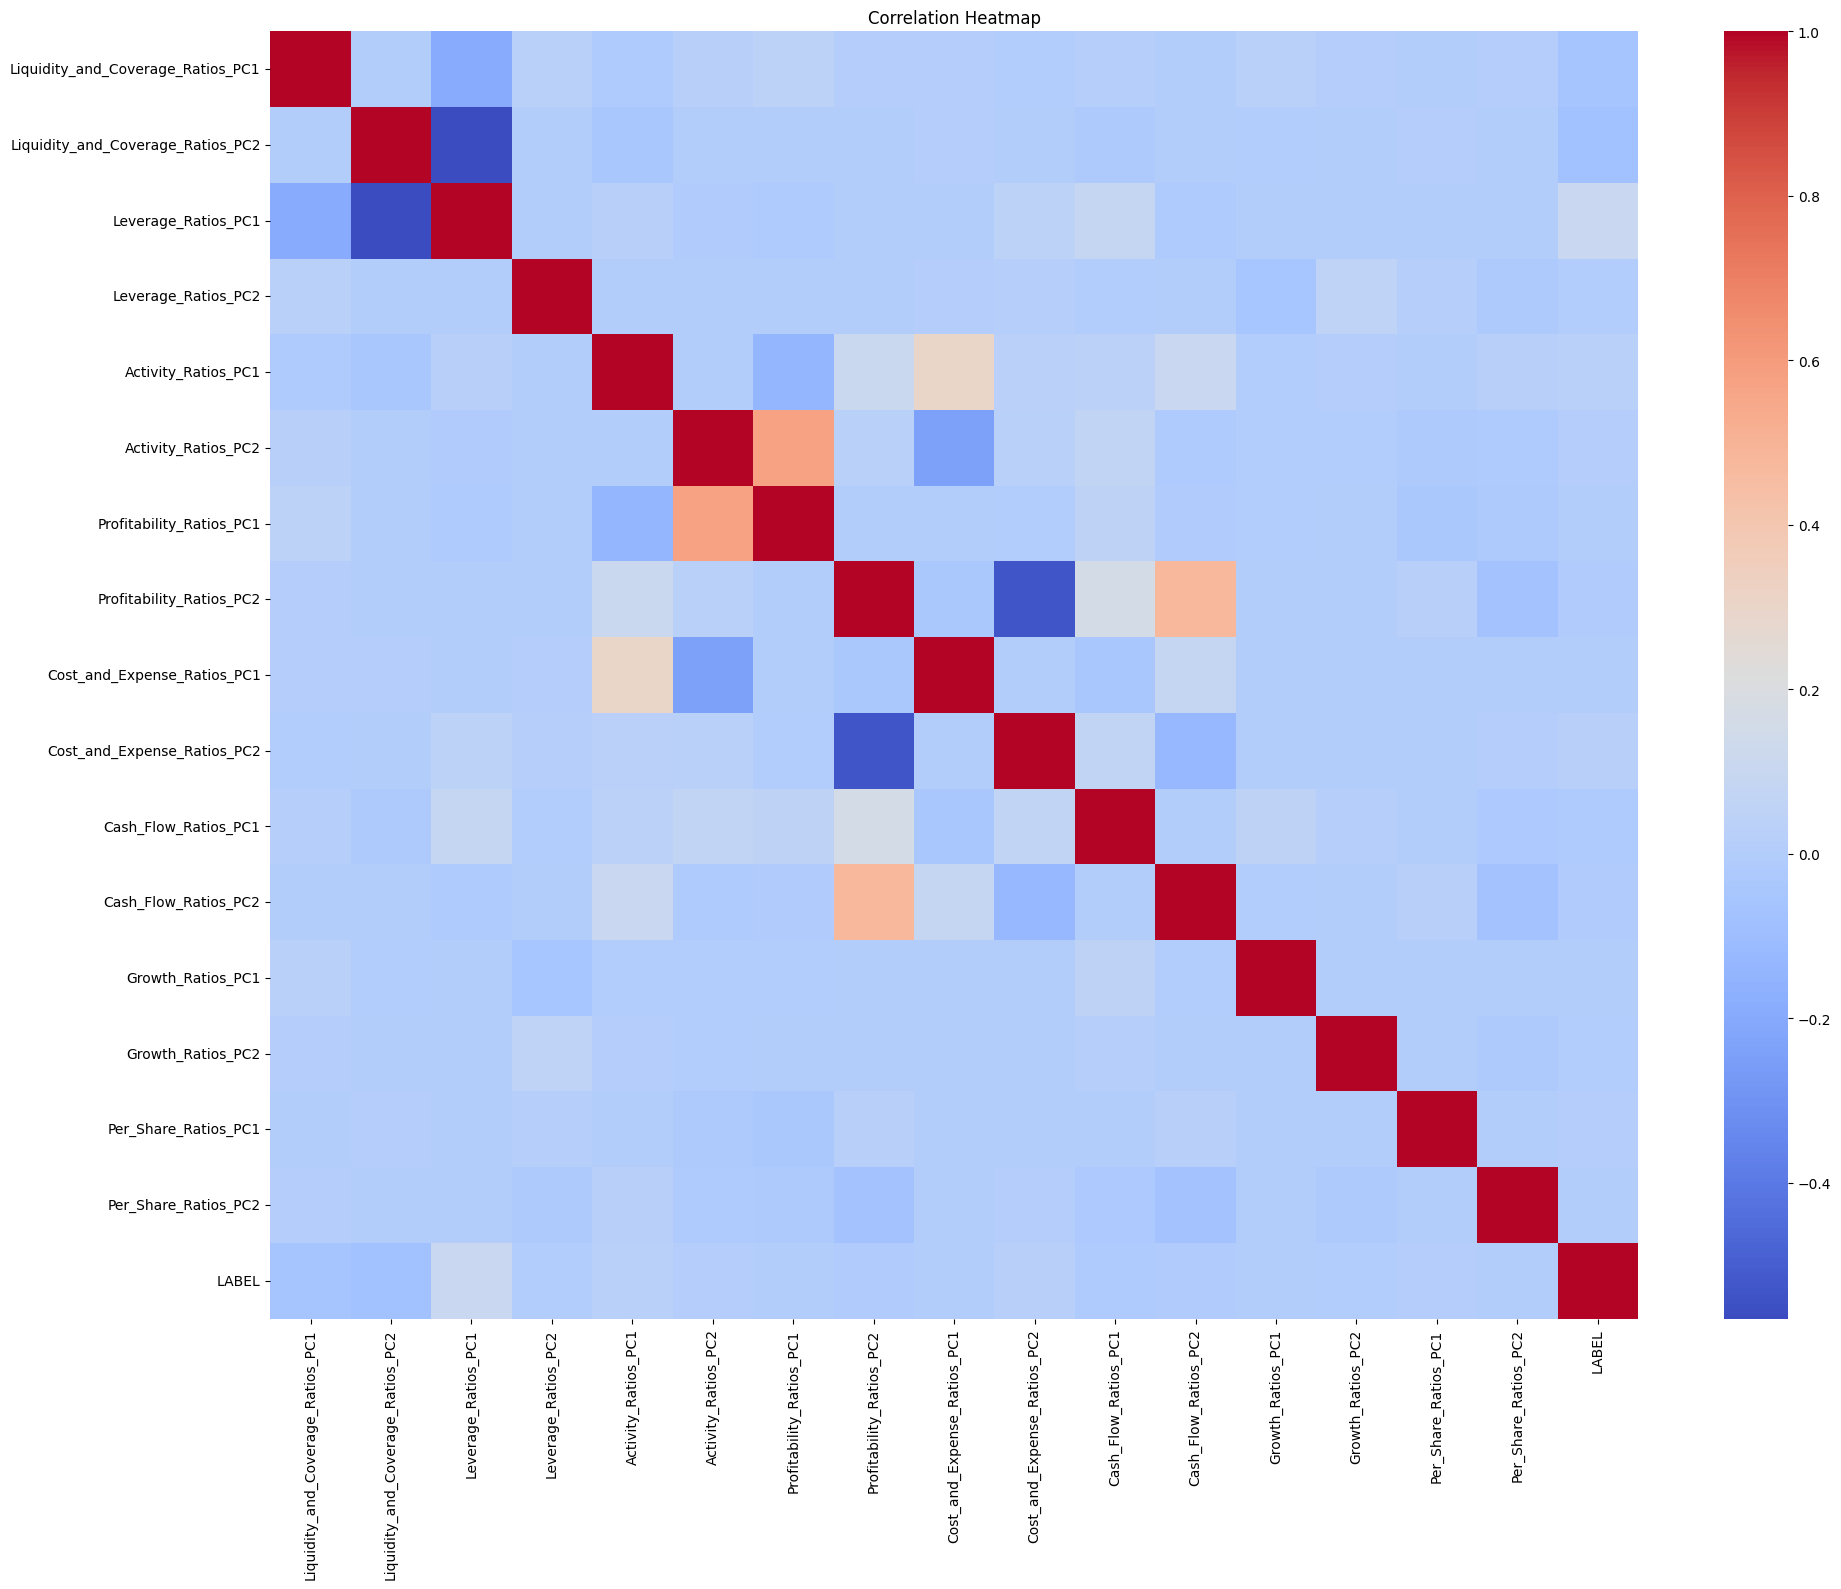


Highly correlated feature pairs:

Number of potential outliers (Isolation Forest): 1402
Number of potential outliers (Z-score > 3): 1191

Skewness of features:
Liquidity_and_Coverage_Ratios_PC1     14.028927
Liquidity_and_Coverage_Ratios_PC2    -40.433924
Leverage_Ratios_PC1                   20.907763
Leverage_Ratios_PC2                   42.766010
Activity_Ratios_PC1                    6.494007
Activity_Ratios_PC2                   52.241408
Profitability_Ratios_PC1             113.021494
Profitability_Ratios_PC2              -6.254178
Cost_and_Expense_Ratios_PC1          113.394506
Cost_and_Expense_Ratios_PC2           51.001307
Cash_Flow_Ratios_PC1                  16.714771
Cash_Flow_Ratios_PC2                  17.575186
Growth_Ratios_PC1                     37.983614
Growth_Ratios_PC2                     55.554343
Per_Share_Ratios_PC1                 -38.058613
Per_Share_Ratios_PC2                   7.943292
LABEL                                  6.533223
dtype: float64

Kurtosi

In [8]:
main(df)